In [1]:
def load_data(input_data_dir:str, num_patches:int=8): 

    '''
    
    Arguments
    ---------

    num_patches : int
        - number of 256x256 patches to randomly sample from input images. 
    
    Notes 
    -----
    This is pretty messy not going to lie. It works though. 

    '''

    from torch.utils.data import DataLoader
    import os 
    import numpy as np
    import torch
    import rasterio 
    from PIL import Image
    from PIL import ImageFile
    from sklearn.model_selection import train_test_split
    from torchvision import transforms
    from torch.utils.data import TensorDataset, DataLoader
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    annotations = [os.path.join(input_data_dir, f'extracted_annotation_{i}.png') for i in range(4)]
    boundaries = [i.replace('extracted_annotation', 'extracted_boundary') for i in annotations]
    ndvi_images = [i.replace('extracted_annotation', 'extracted_ndvi') for i in annotations]
    pan_images = [i.replace('extracted_annotation', 'extracted_pan') for i in annotations]

    #trans = transforms.Compose([transforms.ToTensor()])

    dim = rasterio.open(ndvi_images[0]).read().shape[1:]

    N = num_patches*len(ndvi_images)

    X = np.zeros(shape=(N, 2, 256, 256)) # (N, C, H, W)
    y = np.zeros(shape=(N, 1, 256, 256)) # nice! more efficient...NOTE: used to be 2*dim[-1] for this W to account for weights, but to simplify, I'm just doing annotation on output for now. issue I need to fix later. 
    loss_weight = np.zeros(shape=(N, 256, 256))

    # 1. 
    idx = 0 
    for i in range(len(ndvi_images)):

        ndvi_img = rasterio.open(ndvi_images[i])
        pan_img = rasterio.open(pan_images[i])
        read_ndvi_img = ndvi_img.read()
        read_pan_img = pan_img.read()
      
        annotation_im = Image.open(annotations[i])
        annotation = np.array(annotation_im)
        annotation[annotation<0.5] = 0
        annotation[annotation>=0.5] = 1
        
        #boundaries have a weight of 10 other parts of the image has weight 1
        weight_im = Image.open(boundaries[i])
        weight = np.array(weight_im)
        weight[weight>=0.5] = 10
        weight[weight<0.5] = 1

        # Sample 256x256 Patches
        combined_for_crop = np.zeros(shape=(4, dim[-2], dim[-1]))
        combined_for_crop[0] = read_ndvi_img 
        combined_for_crop[1] = read_pan_img 
        combined_for_crop[2] = annotation 
        combined_for_crop[3] = weight 

        cropper = transforms.RandomCrop(size=(256, 256))
        combined_for_crop = torch.Tensor(combined_for_crop)

        for _ in range(num_patches):
            cropped = cropper(combined_for_crop)
            X[idx][0] = cropped[0]
            X[idx][1] = cropped[1]
            y[idx] = cropped[2]
            loss_weight[idx] = cropped[3]
            
            idx+=1 

    # 2. Split into train / validation partitions
    test_size = 0.1
    val_size = 0.2

    X_train, X_test, y_train, y_test, loss_weight_train, loss_weight_test = train_test_split(X, y, loss_weight, test_size=test_size)
    X_train, X_val, y_train, y_val, loss_weight_train, loss_weight_val = train_test_split(X_train, y_train, loss_weight_train, test_size=val_size)

    # 3. Apply Image Augmentation to training data 

    # 4. Create data loaders
    batch_size = 1
    loader_args = dict(batch_size=batch_size, num_workers=1, pin_memory=True) # os.cpu_count()
    train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train), torch.Tensor(loss_weight_train)), shuffle=True, **loader_args) # Yikes this is messy. clean later. 
    val_loader = DataLoader(TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val), torch.Tensor(loss_weight_val)), shuffle=False, **loader_args)
    test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test), torch.Tensor(loss_weight_test)), shuffle=False, **loader_args)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data('/Users/yaroslav/Documents/Work/NASA/old/data/first-annotations-push/first-shadows-dataset/')


In [2]:
from torchsummary import summary # used to be torchsummary
import torch
import torch.nn as nn
import pytorch_unet

device = 'cpu' 
if torch.backends.mps.is_available(): 
    device = 'mps'

elif torch.cuda.is_available(): 
    device = 'cuda'
device = 'cpu' # fix later...issue somewhere with some of the tensors being cpu, some being mps, even after setting here 
print(f"Using device: {device}")

model = pytorch_unet.UNet(2) # shouldn't it only be n_class =2? 
model = model.to(device)

summary(model, input_size=(2, 1056, 1056))# input_size=(channels, H, W)) # Really mps, but this old summary doesn't support it for some reason

# expects the input to have size [batch_size, channels, depth, height, width] 
# batch_size: 
# channels: 2 for ndvi and pan 
# depth: 

Using device: cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1056, 1056]           1,216
              ReLU-2       [-1, 64, 1056, 1056]               0
            Conv2d-3       [-1, 64, 1056, 1056]          36,928
              ReLU-4       [-1, 64, 1056, 1056]               0
         MaxPool2d-5         [-1, 64, 528, 528]               0
            Conv2d-6        [-1, 128, 528, 528]          73,856
              ReLU-7        [-1, 128, 528, 528]               0
            Conv2d-8        [-1, 128, 528, 528]         147,584
              ReLU-9        [-1, 128, 528, 528]               0
        MaxPool2d-10        [-1, 128, 264, 264]               0
           Conv2d-11        [-1, 256, 264, 264]         295,168
             ReLU-12        [-1, 256, 264, 264]               0
           Conv2d-13        [-1, 256, 264, 264]         590,080
             ReLU-14 

In [3]:
z = next(iter(train_loader))[1]
z[0].shape

print(sum([1 for _ in train_loader]))
print(sum([1 for _ in val_loader]))
print(sum([1 for _ in test_loader]))

22
6
4


In [4]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss
import time
import copy

def torch_tversky(y_true, y_pred, weights, alpha=0.6, beta=0.4):
    """
    Function to calculate the Tversky loss for imbalanced data
    :param y_pred: the logits
    :param y_true: the segmentation ground_truth
    :param weights: the weights of the boundaries 
    :param alpha: weight of false positives
    :param beta: weight of false negatives
    :return: the loss
    """
    
    ones = 1 
    p0 = y_pred  # proba that voxels are class i
    p1 = ones - y_pred  # proba that voxels are not class i
    g0 = y_true
    g1 = ones - y_true

    tp = torch.sum(weights * p0 * g0) # check that it returns same result as tf.reduce_sum
    fp = alpha * torch.sum(weights * p0 * g1)
    fn = beta * torch.sum(weights * p1 * g0)

    EPSILON = 0.00001
    numerator = tp
    denominator = tp + fp + fn + EPSILON
    score = numerator / denominator
    tversky_loss = 1.0 - torch.mean(score) # tf.reduce_mean()

    return tversky_loss

def calc_loss(y_true, y_pred, weights, metrics, bce_weight:float=0.5, alpha:float=0.6, beta:float=0.4):
    tversky_loss = torch_tversky(y_true=y_true, y_pred=y_pred, weights=weights, alpha=alpha, beta=beta)

    pred = torch.sigmoid(y_pred)
    dice = dice_loss(pred, y_true)
    
    metrics['dice'] += dice.data.cpu().numpy() * y_true.size(0)
    metrics['tversky_loss'] += tversky_loss.data.cpu().numpy() * y_true.size(0)

    return tversky_loss

def old_calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            if phase == 'train':
                dataloader = train_loader
            else: 
                dataloader = val_loader

            for inputs, labels, loss_weights in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(y_true=labels, y_pred=outputs, weights=loss_weights, metrics=metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # plz work...I think because it's returning torch tensor, I don't need a 
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['tversky_loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

print(device)

num_class = 2 # maybe num class was the problem? it was 6 before, and I just changed it to 2, and it seems to be working haha. 

model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parame ters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=2)

cpu
Epoch 0/1
----------
LR 0.0001


/opt/homebrew/Caskroom/miniconda/base/envs/cnnheights38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: dice: 0.919440, tversky_loss: 0.951702
val: dice: 0.904883, tversky_loss: 0.910793
saving best model
0m 27s
Epoch 1/1
----------
LR 0.0001
train: dice: 0.916601, tversky_loss: 0.922228
val: dice: 0.904891, tversky_loss: 0.909892
saving best model
0m 26s
Best val loss: 0.909892


In [6]:
# prediction

import math

model.eval()   # Set model to evaluate mode
        
inputs, labels, loss_weights = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = pred.data.cpu().numpy()
print(pred.shape)

print(pred)

(1, 1, 256, 256)
[[[[ 3.4796143  6.629906   8.901994  ...  9.872116   7.4260173
     4.171312 ]
   [ 5.424315  10.699631  14.510035  ... 16.461613  12.361647
     7.0007696]
   [ 7.022769  14.00682   18.809496  ... 21.074112  15.674275
     8.870889 ]
   ...
   [ 9.443629  18.90826   25.261858  ... 17.969393  13.331345
     7.6608233]
   [ 6.9620647 13.94535   18.578989  ... 13.16233    9.834525
     5.64592  ]
   [ 3.5810726  7.045307   9.184152  ...  6.4828334  4.9906654
     2.8543184]]]]


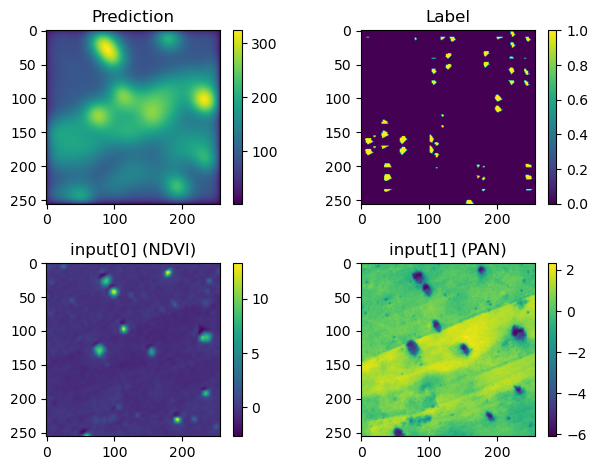

In [7]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(2,2)

a = axs[0,0].imshow(pred[0][0])
plt.colorbar(a, ax=axs[0,0])
axs[0,0].set(title='Prediction')
b = axs[0,1].imshow(labels[0][0])
axs[0,1].set(title='Label')
plt.colorbar(b, ax=axs[0,1])


c = axs[1,0].imshow(inputs[0][0])
plt.colorbar(c, ax=axs[1,0])
axs[1,0].set(title='input[0] (NDVI)')
d = axs[1,1].imshow(inputs[0][1])
plt.colorbar(d, ax=axs[1,1])
axs[1,1].set(title='input[1] (PAN)')

plt.tight_layout()

In [8]:
# need to convert tensor to numpy!

def save_predictions(prediction:torch.Tensor, output_dir:str, crs:str): 
    import os 

    def mask_to_polygons(maskF, transform):
        import cv2
        from shapely.geometry import Polygon
        from collections import defaultdict
        import rasterio
        import numpy as np

        def transformContoursToXY(contours, transform = None):
            tp = []
            for cnt in contours:
                pl = cnt[:, 0, :]
                cols, rows = zip(*pl)
                x,y = rasterio.transform.xy(transform, rows, cols)
                tl = [list(i) for i in zip(x, y)]
                tp.append(tl)
            return (tp)

        # first, find contours with cv2: it's much faster than shapely
        th = 0.5
        mask = maskF.copy()
        mask[mask < th] = 0
        mask[mask >= th] = 1
        mask = ((mask) * 255).astype(np.uint8)
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        
        #Convert contours from image coordinate to xy coordinate
        contours = transformContoursToXY(contours, transform)
        if not contours: #TODO: Raise an error maybe
            print('Warning: No contours/polygons detected!!')
            return [Polygon()]
        # now messy stuff to associate parent and child contours
        cnt_children = defaultdict(list)
        child_contours = set()
        assert hierarchy.shape[0] == 1
        # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
        for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
            if parent_idx != -1:
                child_contours.add(idx)
                cnt_children[parent_idx].append(contours[idx])

        # create actual polygons filtering by area (removes artifacts)
        all_polygons = []

        for idx, cnt in enumerate(contours):
            if idx not in child_contours: #and cv2.contourArea(cnt) >= min_area: #Do we need to check for min_area??
                try:
                    poly = Polygon(
                        shell=cnt,
                        holes=[c for c in cnt_children.get(idx, [])])
                            #if cv2.contourArea(c) >= min_area]) #Do we need to check for min_area??
                    all_polygons.append(poly)
                except:
                    pass
                    # print("An exception occurred in createShapefileObject; Polygon must have more than 2 points")

        return all_polygons

    def writeMaskToDisk(detected_mask, detected_meta, save_path, crs, write_as_type = 'uint8', th = 0.5):
        import geopandas as gpd
        # Convert to correct required before writing
        if 'float' in str(detected_meta['dtype']) and 'int' in write_as_type:
            print(f'Converting prediction from {detected_meta["dtype"]} to {write_as_type}, using threshold of {th}')
            detected_mask[detected_mask<th]=0
            detected_mask[detected_mask>=th]=1 
            detected_mask = detected_mask.astype(write_as_type)
            detected_meta['dtype'] =  write_as_type

        res = mask_to_polygons(detected_mask, detected_meta['transform'])

        d = {'geometry':[i for i in res if i.type == 'Polygon']}
        gdf = gpd.GeoDataFrame(d, crs=crs)
        #gdf = gdf[gdf.geom_type != 'MultiPolygon'] # NOTE THIS FOR FUTURE! HAD TO TAKE OUT GDF!!
        gdf.to_parquet(save_path)#, schema=schema)



    for i in range(prediction.shape[0]):
        detected_meta = {}
        predicted_fp = os.path.join(output_dir, f'predicted_polygons_{i}.geoparquet')
        writeMaskToDisk(detected_mask=prediction.numpy(), detected_meta=detected_meta, save_path=predicted_fp, crs=crs)

In [9]:
print(pred.shape)

(1, 1, 256, 256)
